# Volumetrics


This module that generates circuits on a graph which represents the QPU or QVM lattice. The basic idea is it will compute error rates of circuits as a function of depth and width.

The `width` of the circuit is the number of connected vertices on a particular subgraph.

The `depth` is defined in context-dependent way; to avoid confusion with circuit depth we may use the term 'repetitions'.

In [1]:
import random
import itertools
import networkx as nx
import numpy as np
import time

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer, get_benchmarker
from pyquil.gates import CNOT, CCNOT, Z, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest.benchmarking.volumetrics import *


bm = get_benchmarker()

/home/kylegulshen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Get lattice

In [2]:
from pyquil import *
# if you want to run on a "real lattice"
#list_quantum_computers()
#perfect_qc = get_qc("Aspen-1-16Q-A", as_qvm=True, noisy=False)
#noisy_qc = get_qc("Aspen-1-16Q-A") #, as_qvm=True, noisy=True)

noisy_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=True)
perfect_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=False)

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


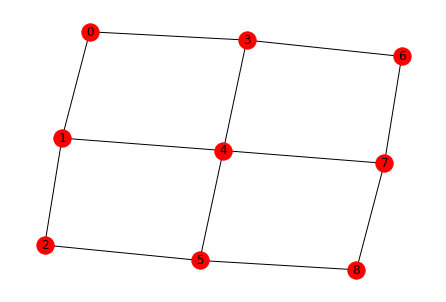

In [3]:
nx.draw(perfect_qc.qubit_topology(),with_labels=True)

In [4]:
G = perfect_qc.qubit_topology()

## Gate sets

### Classical

In [5]:
def two_q_id(qb1,qb2):
    prog = Program()
    prog +=I(qb1)
    prog +=I(qb2)
    return prog

one_c_gates = [X,I]
two_c_gates = [two_q_id, CNOT]
two_c_toffoli = two_c_gates + [CCNOT]

# x basis gates
from forest.benchmarking.classical_logic import CNOT_X_basis, CCNOT_X_basis
one_x_c_gates = [Z, I]
two_x_c_gates = [two_q_id, CNOT_X_basis]
two_x_c_toffoli = two_x_c_gates + [CCNOT_X_basis]
# if you want to do something in the X basis, add Hadamard layers appropriately; see below.

### Some quantum

In [6]:
one_q_gates = [X,Z,I]
two_q_gates = [two_q_id,CZ]

### Random Cliffords

We use a benchmarker for this. Typically we use the native gates from `get_rb_gateset` to implement each clifford.

In [7]:
from forest.benchmarking.randomized_benchmarking import get_rb_gateset
print(bm.generate_rb_sequence(depth=2, gateset=get_rb_gateset([0]))[0])

RX(-pi/2) 0



## Get random gates on a graph

In [8]:
prog1 = random_single_qubit_gates(G, one_q_gates)
prog2 = random_two_qubit_gates(G, two_q_gates)
print(prog1+prog2)

Z 0
X 1
I 2
I 3
X 4
I 5
X 6
X 7
I 8
CZ 0 3
I 0
I 1
CZ 1 4
I 1
I 2
CZ 2 5
CZ 3 6
I 3
I 4
CZ 4 7
I 4
I 5
CZ 5 8
I 6
I 7
CZ 7 8



In [9]:
rand1qcliff = random_single_qubit_cliffords(bm, G)
print(rand1qcliff)

RZ(-pi) 0
RZ(pi/2) 1
RX(-pi) 1
RZ(-pi/2) 2
RX(-pi) 2
RX(pi/2) 3
RZ(pi/2) 3
RZ(pi/2) 4
RX(pi/2) 4
RZ(pi/2) 5
RX(-pi) 5
RZ(pi/2) 6
RX(-pi/2) 6
RX(-pi/2) 7
RZ(-pi/2) 7
RX(-pi/2) 7
RX(pi/2) 8
RZ(-pi/2) 8



## Make some circuit templates and sample programs from them


In [10]:
classical_1q_layer = get_rand_1q_template(one_c_gates)
print(classical_1q_layer.sample_program(G, repetitions=2, width=2))

X 0
X 3
X 0
I 3



In [11]:
classical_2q_layer = get_rand_2q_template(two_c_gates)
print(classical_2q_layer.sample_program(G, repetitions=2, width=2))

I 5
I 8
I 5
I 8



In [12]:
clifford_1q_layer = get_rand_1q_cliff_template(bm)
clifford_2q_layer = get_rand_2q_cliff_template(bm)
print(clifford_2q_layer.sample_program(G, repetitions=2, width=2))

RX(-pi/2) 7
RX(pi/2) 6
CZ 6 7
RX(pi/2) 7
RZ(pi/2) 7
RX(pi/2) 6
CZ 6 7
RX(pi/2) 7
RZ(pi/2) 7
RX(-pi/2) 7
RX(-pi/2) 6



In [13]:
rand_su4_layer = get_rand_su4_template()
print(rand_su4_layer.sample_program(G, 1, qc=noisy_qc, width=2))


DEFGATE LYR0_RSU4_7_8:
    -0.17133680286283015+0.5771855029770466i, -0.02466156348536916+0.22179234545831975i, 0.12228377642992853+0.14496205601880133i, -0.2297884080173649+0.7063501439074774i
    -0.11960102370866607-0.3304433900630011i, -0.11032673672938412-0.42880536505067257i, 0.7357619987654005+0.3068282033583267i, 0.06383311224299526+0.2022196818708112i
    -0.26202392947509057+0.06665775229723633i, -0.3849027928296902-0.5194528926129671i, -0.5291269370112102+0.144305312790629i, 0.3979354224512658+0.22308473201253587i
    -0.042541944416586486-0.6626414895218656i, -0.19559242672520571+0.545816881274874i, -0.1609407499642989+0.04292029081848708i, 0.14224663636027113+0.418265217456327i

LYR0_RSU4_7_8 7 8



## Compose templates

In [14]:
classical_1q_2q = classical_1q_layer + classical_2q_layer
print(classical_1q_2q.sample_program(G, repetitions=2, width=4))

X 4
I 5
I 6
X 7
CNOT 4 7
I 4
I 5
I 6
I 7
I 4
I 5
X 6
I 7
CNOT 4 7
I 4
I 5
CNOT 6 7



Classical Logic in X basis

Add a `sequence_transform` for the template to insert the basis change H gates at beginning and end.

In [15]:
classical_x_1q_2q = get_rand_1q_template(one_x_c_gates) + get_rand_2q_template(two_x_c_gates)
# here we demonstrate a simple use of a sequence_transform. We want to switch to the x basis 
# at thebeginning of our circuite and switch back to the Z basis before measurement. 
# To accomplish this we set a 'sequnce_transform' to be applied after the circuit sequence is generated.
classical_x_1q_2q.sequence_transforms.append(hadamard_sandwich)
print(classical_x_1q_2q.sample_program(G, repetitions=3, width=2))
# note that the x basis CNOT(0, 1) is H(0) CZ(0, 1) H(0)

H 2
H 5
Z 2
Z 5
I 2
I 5
Z 2
I 5
H 2
CZ 2 5
H 2
I 2
I 5
I 2
I 5
H 2
H 5



Daggering the circuit to get a self-inverting sandwich.
Here we again add a `sequence_transform` to transform the sampled sequence by appending its dagger (aka Hermitian conjugate, adjoint, etc.).

In [16]:
clifford_sandwich = clifford_1q_layer + clifford_2q_layer
clifford_sandwich.sequence_transforms.append(dagger_sequence)
prog = clifford_sandwich.sample_program(G, repetitions=3, width=2,  qc=noisy_qc)
print(prog)

# We can check that this is the identity by compiling it fully
print("This program compiles away to nothing: ")
print(noisy_qc.compiler.quil_to_native_quil(prog))

RX(pi/2) 0
RZ(-pi) 0
RX(-pi/2) 1
RZ(-pi/2) 1
CZ 0 1
RX(-pi/2) 1
RZ(-pi/2) 0
RX(-pi/2) 0
CZ 0 1
RX(-pi/2) 1
RX(-pi/2) 0
CZ 0 1
RX(-pi/2) 0
RZ(-pi/2) 0
RX(-pi/2) 0
RX(pi/2) 1
RZ(-pi/2) 1
RX(-pi/2) 1
RX(pi/2) 1
CZ 0 1
RZ(-pi/2) 1
RX(pi/2) 0
RZ(-pi/2) 0
RZ(pi/2) 1
RX(-pi) 1
CZ 0 1
RX(-pi/2) 1
CZ 0 1
RZ(pi/2) 0
DAGGER RZ(pi/2) 0
DAGGER CZ 0 1
DAGGER RX(-pi/2) 1
DAGGER CZ 0 1
DAGGER RX(-pi) 1
DAGGER RZ(pi/2) 1
DAGGER RZ(-pi/2) 0
DAGGER RX(pi/2) 0
DAGGER RZ(-pi/2) 1
DAGGER CZ 0 1
DAGGER RX(pi/2) 1
DAGGER RX(-pi/2) 1
DAGGER RZ(-pi/2) 1
DAGGER RX(pi/2) 1
DAGGER RX(-pi/2) 0
DAGGER RZ(-pi/2) 0
DAGGER RX(-pi/2) 0
DAGGER CZ 0 1
DAGGER RX(-pi/2) 0
DAGGER RX(-pi/2) 1
DAGGER CZ 0 1
DAGGER RX(-pi/2) 0
DAGGER RZ(-pi/2) 0
DAGGER RX(-pi/2) 1
DAGGER CZ 0 1
DAGGER RZ(-pi/2) 1
DAGGER RX(-pi/2) 1
DAGGER RZ(-pi) 0
DAGGER RX(pi/2) 0

This program compiles away to nothing: 
HALT



### Quantum Volume

In [17]:
qv_template = rand_su4_layer
# we want to compile the output sequences with graph-restricted compilation.
qv_template.sequence_transforms.append(compile_merged_sequence)
qv_prog = qv_template.sample_program(G, repetitions=2, qc=noisy_qc, width=4)
print(qv_prog)

RZ(-2.231268474427302) 1
RX(pi/2) 1
RZ(2.0191195178095818) 1
RX(-pi/2) 1
RZ(-1.1356120065188826) 1
RZ(1.888479542178537) 4
RX(pi/2) 4
RZ(1.5084431913342584) 4
RX(-pi/2) 4
RZ(-2.483042302320226) 4
CZ 1 4
RZ(-pi/2) 1
RX(-pi/2) 1
RZ(pi/2) 4
RX(pi/2) 4
RZ(2.2967439629061275) 4
RX(-pi/2) 4
CZ 1 4
RZ(1.911765822813055) 1
RX(pi/2) 1
RX(pi/2) 4
RZ(-2.0754631531787293) 4
RX(-pi/2) 4
CZ 1 4
RZ(1.3367732406777537) 5
RX(pi/2) 5
RZ(1.2981763099836934) 5
RX(-pi/2) 5
RZ(1.7352147829475575) 5
RZ(0.22008114899935705) 0
RX(pi/2) 0
RZ(1.7971328131102209) 0
RX(-pi/2) 0
RZ(0.9352242822990644) 0
RZ(-2.8993914186145995) 1
RX(pi/2) 1
RZ(1.447488760525238) 1
RX(-pi/2) 1
CZ 1 0
RZ(-0.8424737294501448) 0
RX(pi/2) 0
RZ(2.2991189241396484) 1
RX(-pi/2) 1
CZ 1 0
RX(-pi/2) 0
RX(pi/2) 1
CZ 1 0
RZ(-1.8937028386273451) 4
RX(pi/2) 4
RZ(1.8351213808969726) 4
RX(-pi/2) 4
CZ 5 4
RZ(-1.2810926274779872) 4
RX(pi/2) 4
RZ(-pi/2) 5
RX(-pi/2) 5
CZ 5 4
RX(-pi/2) 4
RX(pi/2) 5
CZ 5 4
RZ(0.9186884109193686) 0
RX(pi/2) 0
RZ(0.97236858

## Run quantum volume for one width and depth

1. Generate the programs
2. Determine the heavy outputs
3. Collect experimental data

In [18]:
start_time = time.time()
from pyquil.numpy_simulator import NumpyWavefunctionSimulator
wfn_sim = NumpyWavefunctionSimulator(9)
d = 2
dimensions = {d: [d]}
qv_progs = generate_volumetric_program_array(perfect_qc, qv_template, 
                                             dimensions, num_circuit_samples=200)
heavy_outputs = collect_heavy_outputs(wfn_sim, qv_progs)
experimental_data = acquire_volumetric_data(perfect_qc, qv_progs)

In [19]:
qvol_success_probs = get_success_probabilities(experimental_data, heavy_outputs)
print(qvol_success_probs)
print(np.average(qvol_success_probs[d][d]))

{2: {2: [0.7340000000000005, 0.8380000000000006, 0.6160000000000004, 0.6560000000000005, 0.8960000000000007, 0.7760000000000006, 0.7300000000000005, 0.9020000000000007, 0.8040000000000006, 0.6800000000000005, 0.7880000000000006, 0.8960000000000007, 0.8320000000000006, 0.8480000000000006, 0.8340000000000006, 0.7780000000000006, 0.8400000000000006, 0.6980000000000005, 0.6380000000000005, 0.8100000000000006, 0.7460000000000006, 0.6700000000000005, 0.6120000000000004, 0.8860000000000007, 0.8240000000000006, 0.8060000000000006, 0.6460000000000005, 0.7560000000000006, 0.6700000000000005, 0.8240000000000006, 0.8020000000000006, 0.8200000000000006, 0.7700000000000006, 0.9380000000000007, 0.8220000000000006, 0.8420000000000006, 0.7640000000000006, 0.8440000000000006, 0.8620000000000007, 0.6460000000000005, 0.7360000000000005, 0.7500000000000006, 0.7260000000000005, 0.7100000000000005, 0.6620000000000005, 0.9120000000000007, 0.6600000000000005, 0.8580000000000007, 0.6780000000000005, 0.798000000

In [20]:
qvol_successes = determine_successes(qvol_success_probs, 500)
print(qvol_successes)
end_time = time.time()
print(end_time - start_time)
print(determine_prob_success_lower_bounds(qvol_success_probs, 500))

{2: {2: True}}
42.56635141372681
{2: {2: 0.7377093761897142}}


## Acquire data for ranges of (width, depth)

In [21]:
widths = [2, 3, 4, 5]
depths = [2, 3, 4, 5, 10]
dimensions = {w: depths for w in widths}
ckt_family = classical_1q_2q
prog_array = generate_volumetric_program_array(noisy_qc, ckt_family, dimensions, num_circuit_samples=20)
print(prog_array)

{2: {2: [<pyquil.quil.Program object at 0x7f5ca4da3d68>, <pyquil.quil.Program object at 0x7f5ca4d00be0>, <pyquil.quil.Program object at 0x7f5ca4d00160>, <pyquil.quil.Program object at 0x7f5ca4b547b8>, <pyquil.quil.Program object at 0x7f5ca4b542b0>, <pyquil.quil.Program object at 0x7f5ca4b54d30>, <pyquil.quil.Program object at 0x7f5ca4d00780>, <pyquil.quil.Program object at 0x7f5ca5053f60>, <pyquil.quil.Program object at 0x7f5ca50539b0>, <pyquil.quil.Program object at 0x7f5ca5053b00>, <pyquil.quil.Program object at 0x7f5ca4b29b38>, <pyquil.quil.Program object at 0x7f5ca4b298d0>, <pyquil.quil.Program object at 0x7f5ca4afb940>, <pyquil.quil.Program object at 0x7f5ca4afb630>, <pyquil.quil.Program object at 0x7f5ca4afb518>, <pyquil.quil.Program object at 0x7f5ca4d65e10>, <pyquil.quil.Program object at 0x7f5ca4d65a20>, <pyquil.quil.Program object at 0x7f5ca4b299b0>, <pyquil.quil.Program object at 0x7f5ca4b54b00>, <pyquil.quil.Program object at 0x7f5ca4a65128>], 3: [<pyquil.quil.Program objec

In [22]:
num_shots = 500
noisy_results = acquire_volumetric_data(noisy_qc, prog_array, num_shots)

In [23]:
ideal_results = acquire_volumetric_data(perfect_qc, prog_array, num_shots=1)
print(ideal_results)

{2: {2: [array([[1, 1]]), array([[1, 1]]), array([[1, 1]]), array([[1, 0]]), array([[1, 1]]), array([[0, 1]]), array([[1, 1]]), array([[0, 0]]), array([[1, 1]]), array([[1, 1]]), array([[1, 1]]), array([[0, 1]]), array([[0, 0]]), array([[0, 1]]), array([[1, 0]]), array([[1, 0]]), array([[1, 1]]), array([[0, 0]]), array([[0, 1]]), array([[0, 0]])], 3: [array([[1, 0]]), array([[1, 1]]), array([[0, 0]]), array([[0, 0]]), array([[0, 1]]), array([[1, 1]]), array([[0, 1]]), array([[0, 0]]), array([[1, 1]]), array([[1, 0]]), array([[1, 0]]), array([[1, 0]]), array([[1, 0]]), array([[0, 1]]), array([[0, 0]]), array([[1, 0]]), array([[0, 0]]), array([[0, 0]]), array([[1, 0]]), array([[1, 0]])], 4: [array([[0, 1]]), array([[0, 0]]), array([[1, 1]]), array([[0, 1]]), array([[1, 0]]), array([[0, 1]]), array([[0, 1]]), array([[0, 1]]), array([[1, 1]]), array([[0, 0]]), array([[1, 0]]), array([[0, 0]]), array([[0, 0]]), array([[0, 1]]), array([[0, 0]]), array([[1, 0]]), array([[0, 0]]), array([[0, 1

In [24]:
err_hamm_distrs = get_error_hamming_weight_distributions(noisy_results, ideal_results)
print(err_hamm_distrs)

{2: {2: [array([0.834, 0.158, 0.008]), array([0.84 , 0.154, 0.006]), array([0.834, 0.162, 0.004]), array([0.9  , 0.098, 0.002]), array([0.842, 0.15 , 0.008]), array([0.92 , 0.078, 0.002]), array([0.812, 0.18 , 0.008]), array([0.944, 0.056, 0.   ]), array([0.818, 0.168, 0.014]), array([0.832, 0.156, 0.012]), array([0.812, 0.182, 0.006]), array([0.89 , 0.106, 0.004]), array([0.95, 0.05, 0.  ]), array([0.892, 0.104, 0.004]), array([0.866, 0.134, 0.   ]), array([0.896, 0.102, 0.002]), array([0.83 , 0.158, 0.012]), array([0.942, 0.058, 0.   ]), array([0.874, 0.124, 0.002]), array([0.938, 0.06 , 0.002])], 3: [array([0.916, 0.084, 0.   ]), array([0.872, 0.118, 0.01 ]), array([0.95 , 0.048, 0.002]), array([0.958, 0.042, 0.   ]), array([0.894, 0.106, 0.   ]), array([0.832, 0.162, 0.006]), array([0.882, 0.114, 0.004]), array([0.948, 0.052, 0.   ]), array([0.846, 0.136, 0.018]), array([0.888, 0.108, 0.004]), array([0.9  , 0.098, 0.002]), array([0.874, 0.122, 0.004]), array([0.852, 0.146, 0.002]),

In [25]:
avg_err_hamm_distrs = average_distributions(err_hamm_distrs)
print(avg_err_hamm_distrs)

{2: {2: array([0.8733, 0.1219, 0.0048]), 3: array([0.8967, 0.1002, 0.0031]), 4: array([0.8992, 0.097 , 0.0038]), 5: array([0.8772, 0.1185, 0.0043]), 10: array([0.8844, 0.1077, 0.0079])}, 3: {2: array([8.268e-01, 1.613e-01, 1.120e-02, 7.000e-04]), 3: array([8.299e-01, 1.594e-01, 1.000e-02, 7.000e-04]), 4: array([8.211e-01, 1.658e-01, 1.230e-02, 8.000e-04]), 5: array([0.8446, 0.1441, 0.0103, 0.001 ]), 10: array([8.200e-01, 1.614e-01, 1.790e-02, 7.000e-04])}, 4: {2: array([8.000e-01, 1.774e-01, 1.970e-02, 2.800e-03, 1.000e-04]), 3: array([7.803e-01, 1.962e-01, 2.200e-02, 1.400e-03, 1.000e-04]), 4: array([0.7749, 0.2023, 0.0219, 0.0009, 0.    ]), 5: array([7.796e-01, 1.934e-01, 2.400e-02, 2.500e-03, 5.000e-04]), 10: array([0.7812, 0.1907, 0.023 , 0.0041, 0.001 ])}, 5: {2: array([7.544e-01, 2.144e-01, 2.900e-02, 1.800e-03, 3.000e-04, 1.000e-04]), 3: array([7.302e-01, 2.330e-01, 3.180e-02, 4.200e-03, 7.000e-04, 1.000e-04]), 4: array([7.378e-01, 2.259e-01, 2.930e-02, 5.300e-03, 1.300e-03, 4.0

## Plot a particular depth and width

In [26]:
w = 3 # width
d = 4 # depth

avg_distr = avg_err_hamm_distrs[3][4]

# rand data
rand_distr = get_random_hamming_wt_distr(w)

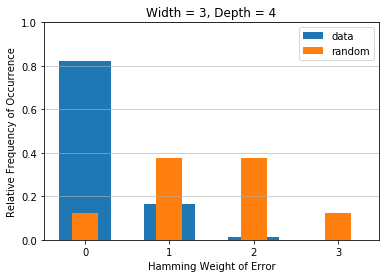

In [27]:
x_labels = np.arange(0, len(avg_distr))
plt.bar(x_labels, avg_distr, width=0.61, align='center')
plt.bar(x_labels, rand_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurrence')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title(f'Width = {w}, Depth = {d}')
plt.show()

Using our helper function

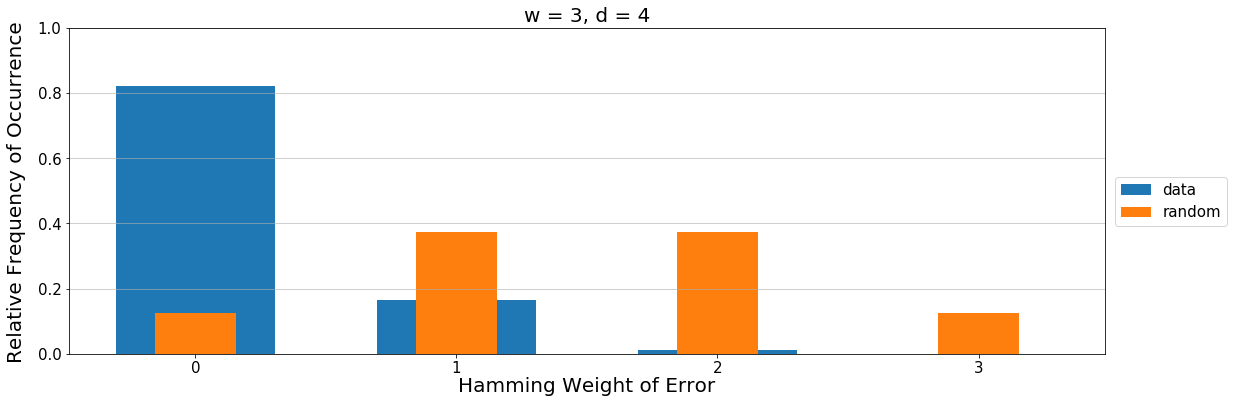

In [28]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=[w], depths=[d], plot_rand_distr=True)

### For a particular width, plot all depths

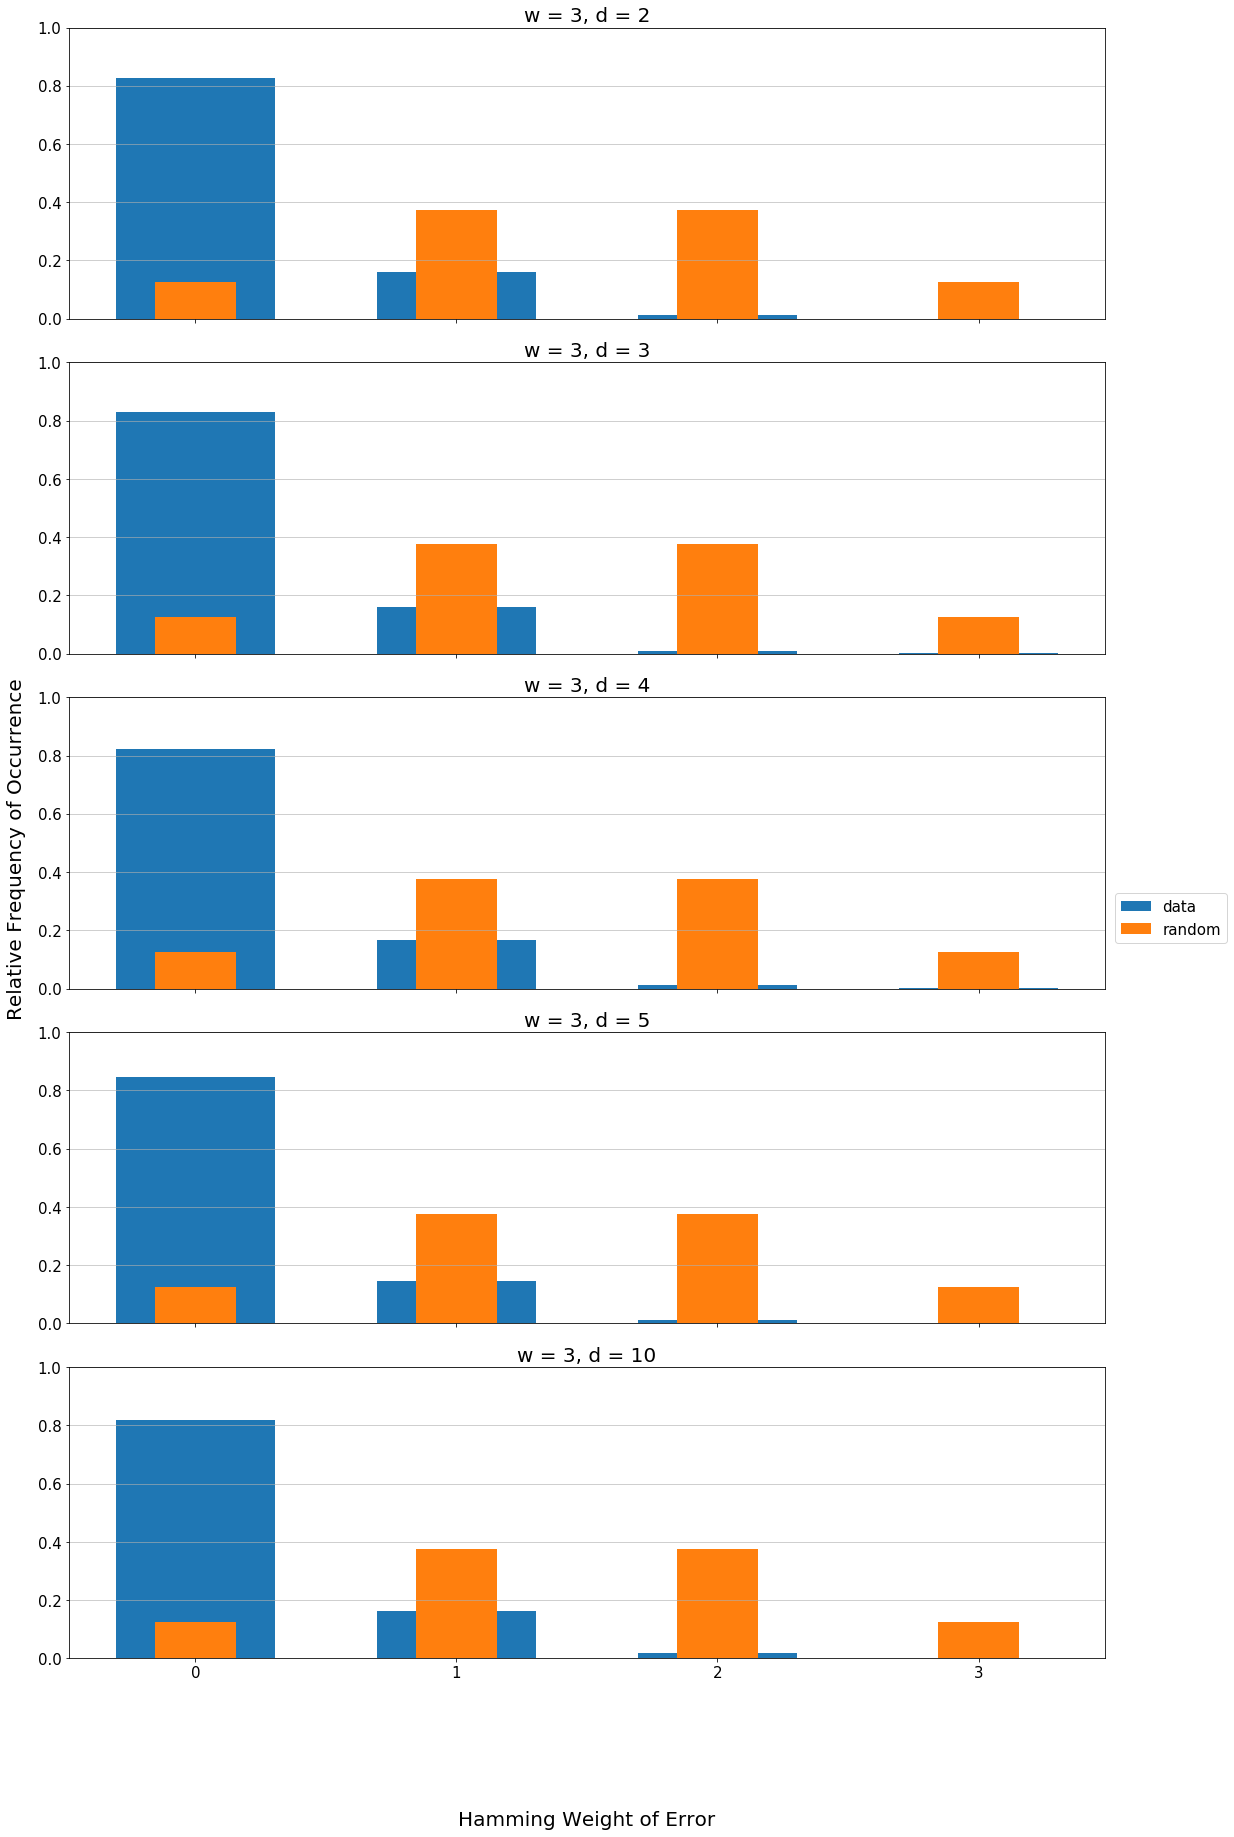

In [29]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=[w], plot_rand_distr=True)

### Plot all of the distributions

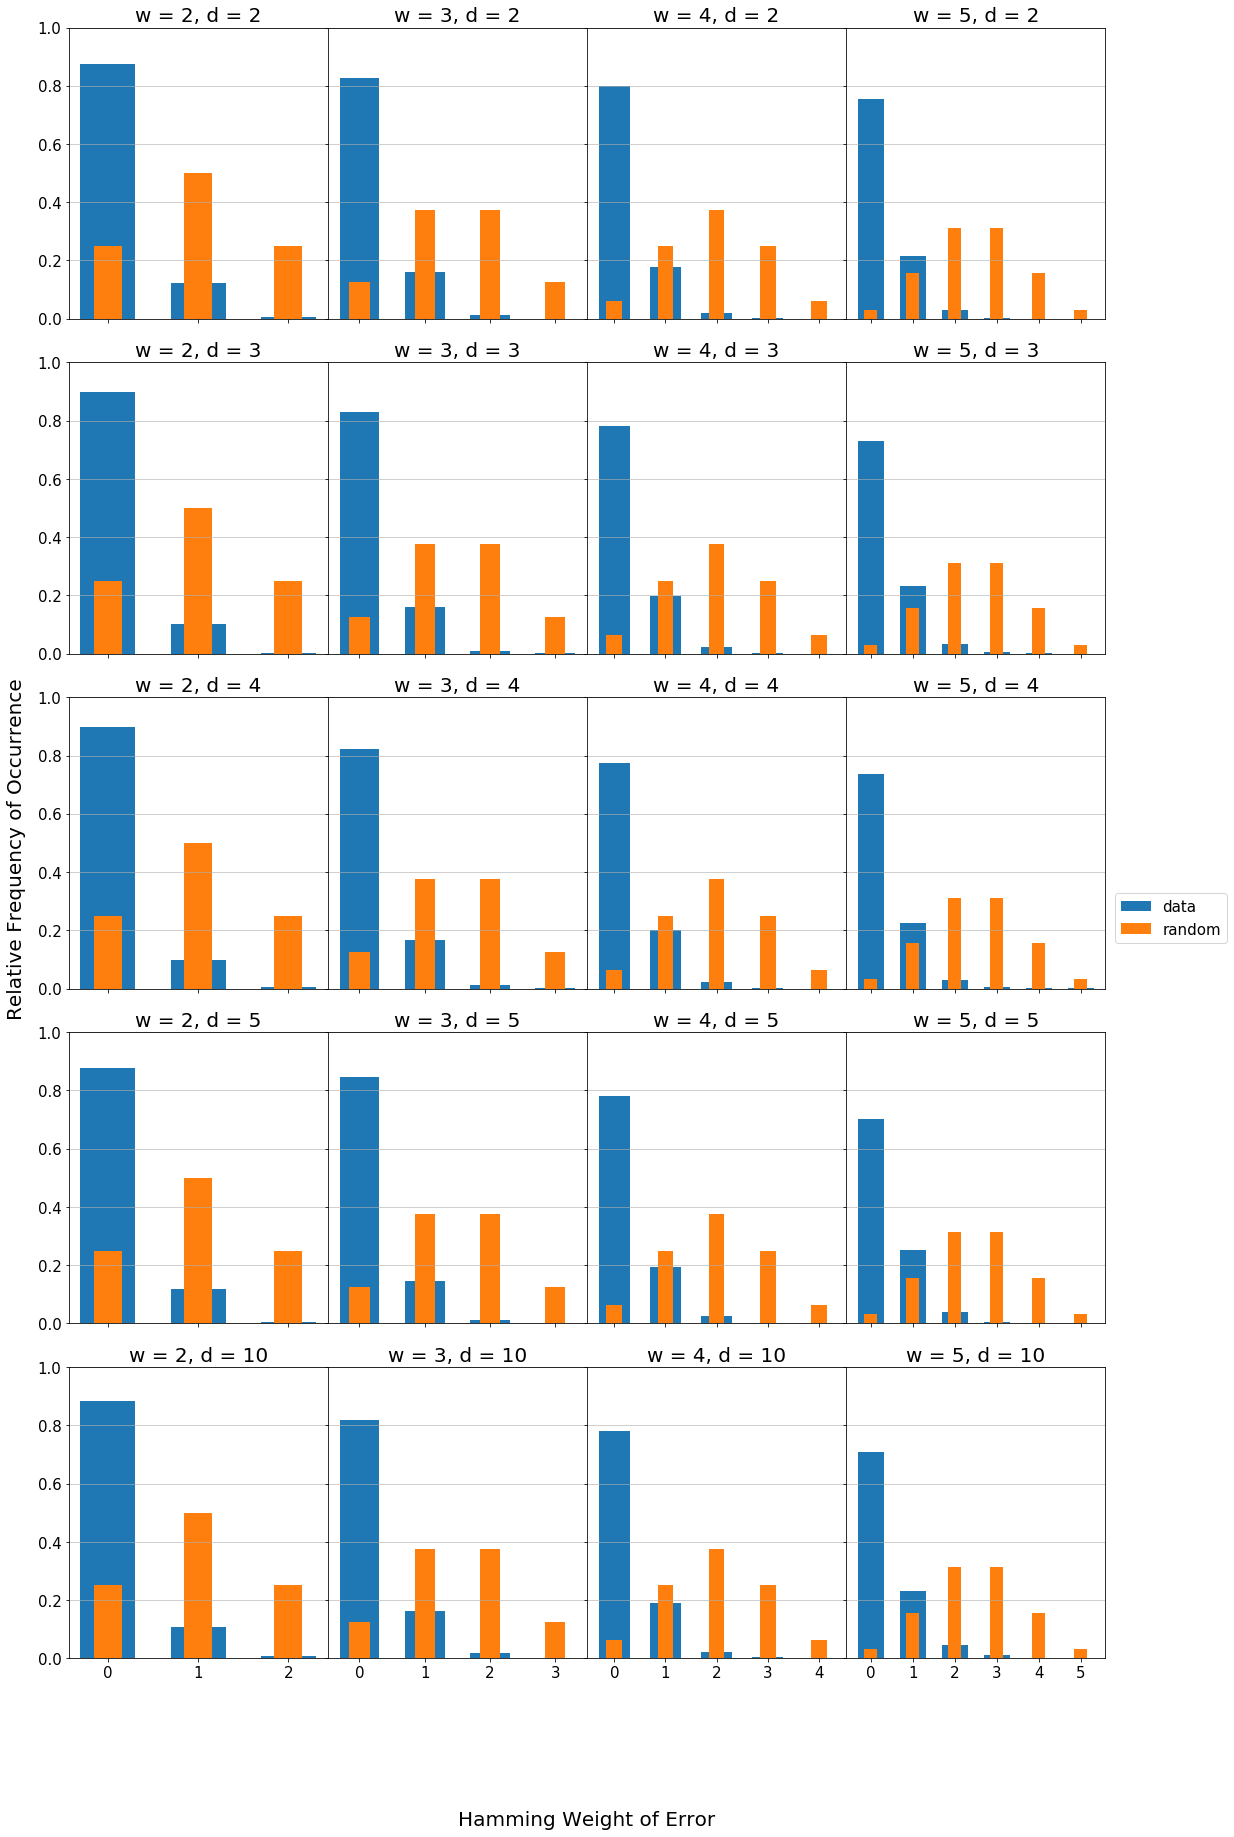

In [30]:
fig, axs = plot_error_distributions(avg_err_hamm_distrs, widths=None, depths=None, plot_rand_distr=True)

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data.

In [31]:
# extract data from avg_err_hamm_distrs
widths = list(avg_err_hamm_distrs.keys())
depths = list(avg_err_hamm_distrs[widths[0]].keys())

# get the probability of success for each circuit sampled
succ_probs = get_single_target_success_probabilities(noisy_results, ideal_results)

# get the average probability of success over all samples
avg_pr_succ_arr = {w: {d: distr[0] for d, distr in d_distrs.items()} for w, d_distrs in avg_err_hamm_distrs.items()}
# this is equivalently wrapped up in the following
assert avg_pr_succ_arr == average_distributions(succ_probs)

# count as success even if there are log many bits incorrect.
avg_pr_succ_allow_log_errors = average_distributions(get_single_target_success_probabilities(noisy_results, 
                                                                                             ideal_results, 
                                                     allowed_errors = basement_log_function))

ideal_distrs = {w: [1] + [0 for _ in range(w)] for w in widths}
rand_distrs = {w: get_random_hamming_wt_distr(w) for w in widths}

pr_succ_rand = {w: 1/2**w for w in widths}
pr_succ_rand_allow_log_errors = {w: sum(rand_distrs[w][0:basement_log_function(w)+1]) for w in widths}

# total variation distance
tvd_noisy_ideal = {w: {d: get_total_variation_dist(distr, ideal_distrs[w]) for d, distr in d_distrs.items()}
                              for w, d_distrs in avg_err_hamm_distrs.items()}

# tvd_noisy_ideal is equivalent to 1 - success probability.
np.testing.assert_allclose([pr for d_vals in avg_pr_succ_arr.values() for pr in d_vals.values()], 
                           [1 - val for d_vals in tvd_noisy_ideal.values() for val in d_vals.values()])

tvd_noisy_rand = {w: {d: get_total_variation_dist(distr, rand_distrs[w]) for d, distr in d_distrs.items()}
                              for w, d_distrs in avg_err_hamm_distrs.items()}

print(avg_pr_succ_arr)
print(avg_pr_succ_allow_log_errors)
print(tvd_noisy_rand)

{2: {2: 0.8732999999999999, 3: 0.8967, 4: 0.8992000000000001, 5: 0.8772, 10: 0.8844000000000001}, 3: {2: 0.8267999999999999, 3: 0.8299, 4: 0.8211, 5: 0.8446, 10: 0.8200000000000001}, 4: {2: 0.8, 3: 0.7802999999999999, 4: 0.7749, 5: 0.7796000000000001, 10: 0.7811999999999999}, 5: {2: 0.7544000000000001, 3: 0.7302000000000002, 4: 0.7378, 5: 0.7012, 10: 0.7077999999999999}}
{2: {2: 0.9952000000000002, 3: 0.9968999999999999, 4: 0.9962, 5: 0.9957, 10: 0.9921000000000001}, 3: {2: 0.9881000000000002, 3: 0.9892999999999998, 4: 0.9869, 5: 0.9887, 10: 0.9814}, 4: {2: 0.9971, 3: 0.9984999999999999, 4: 0.9991000000000001, 5: 0.9969999999999999, 10: 0.9948999999999998}, 5: {2: 0.9978, 3: 0.9949999999999999, 4: 0.9930000000000001, 5: 0.9934, 10: 0.9849}}
{2: {2: 0.6233, 3: 0.6467, 4: 0.6492, 5: 0.6272, 10: 0.6344}, 3: {2: 0.7018, 3: 0.7049, 4: 0.6961, 5: 0.7196, 10: 0.6950000000000001}, 4: {2: 0.7375, 3: 0.7177999999999999, 4: 0.7123999999999999, 5: 0.7171000000000001, 10: 0.7186999999999999}, 5: {2

## Success probablity and success probablity including a small number of errors

Next we will plot the success probablity of a circuit with a certain width as a function of depth. 

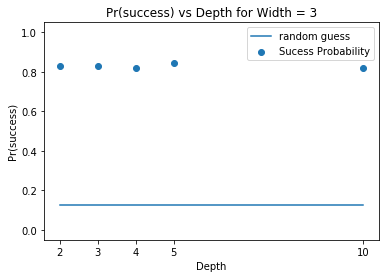

In [32]:
w=3
plt.scatter(depths, [avg_pr_succ_arr[w][d] for d in depths], label='Sucess Probability')
plt.plot(depths, [pr_succ_rand[w] for _ in depths], label='random guess')
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(w))
plt.legend()
plt.show()

**Sucess if we allow for a small number of errors**

Some near term algorithms have robustness to noise. In light of that we might want to consider as successes answers that are only a little wrong.

To make this notion formal we allow a logarithmic number of bits to be flipped from the correct answer and call all such instances "success".

The logarithmic number of bits that we allow to flip is defined by the "basement" ${\mathcal B}$ of 

$\log_2 ({\rm number\ of\ bits})$

where the basement of a number is ${\mathcal B}(number) = 0$ if number$<=0$ and ${\mathcal B}(number) = {\rm floor (number)}$.


Supose we have a circuit of width 4 so that the correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4) = 2$.

So any string with hamming weight zero, one, or two counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

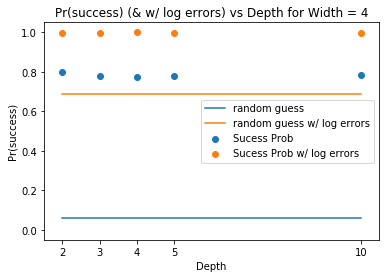

In [33]:
w=4
plt.scatter(depths, [avg_pr_succ_arr[w][d] for d in depths], label='Sucess Prob')
plt.plot(depths, [pr_succ_rand[w] for _ in depths], label='random guess')
plt.scatter(depths, [avg_pr_succ_allow_log_errors[w][d] for d in depths], label='Sucess Prob w/ log errors')
plt.plot(depths, [pr_succ_rand_allow_log_errors[w] for _ in depths], label='random guess w/ log errors')
plt.ylim([-0.05, 1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Pr(success)')
plt.title('Pr(success) (& w/ log errors) vs Depth for Width = {}'.format(w))
plt.legend()
plt.show()

## Total variation distance from ideal answer and random distribution

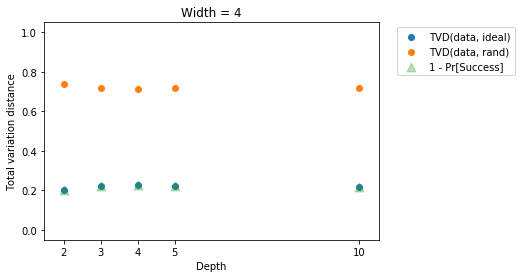

In [34]:
plt.figure()
plt.scatter(depths, [tvd_noisy_ideal[w][d] for d in depths], label='TVD(data, ideal)')
plt.scatter(depths, [tvd_noisy_rand[w][d] for d in depths], label='TVD(data, rand)')
plt.scatter(depths, 1-np.asarray([avg_pr_succ_arr[w][d] for d in depths]),
            label='1 - Pr[Success]', alpha=0.33, marker='^', s=80)
plt.ylim([-0.05,1.05])
plt.xlabel('Depth')
plt.xticks(depths)
plt.ylabel('Total variation distance')
plt.title('Width = {}'.format(w))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

## Plot success probablity landscape

This is just the success probablity as a function of depth and width.

In [35]:
X, Y = np.meshgrid(widths, depths)

In [36]:
Zdata = np.reshape([avg_pr_succ_arr[w][d] for d in depths for w in widths], X.shape)
Zrand = np.reshape([pr_succ_rand[w] for d in depths for w in widths], X.shape)

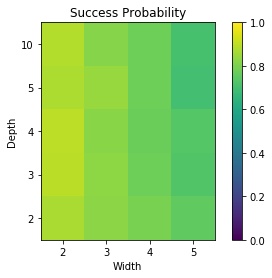

In [37]:
extent = -0.5, len(widths) - 0.5, -0.5, len(depths) - 0.5
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0, vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success Probability')
plt.show()

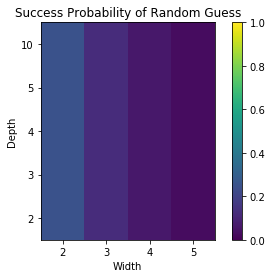

In [38]:
ax = plt.gca()
img = ax.imshow(Zrand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success Probability of Random Guess')
plt.show()

(<Figure size 288x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ca3db4e48>)

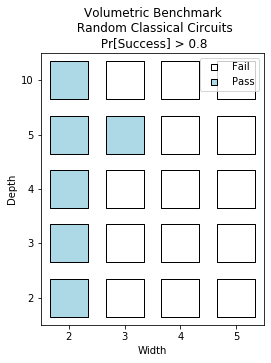

In [39]:
success_threshold = .8
ckt_success_probs = get_single_target_success_probabilities(noisy_results, ideal_results)
successes = determine_successes(ckt_success_probs, num_shots)
plot_success(successes, f"Volumetric Benchmark\n Random Classical Circuits\n Pr[Success] > {success_threshold}")

(<Figure size 360x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ca43975c0>)

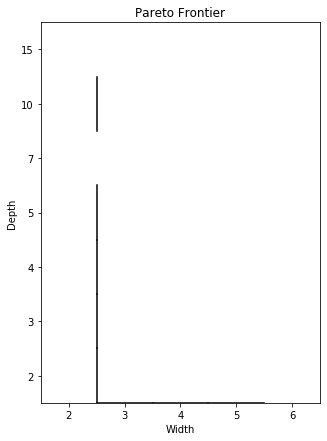

In [40]:
fake_successes = successes
plot_pareto_frontier(successes, 'Pareto Frontier', widths=[2,3,4,5,6], depths = [2,3,4,5,7,10,15])

## Plot total variation distance landscape

In [41]:
Ztvd_ideal = np.reshape([tvd_noisy_ideal[w][d] for d in depths for w in widths], X.shape)
Ztvd_rand = np.reshape([tvd_noisy_rand[w][d] for d in depths for w in widths], X.shape)

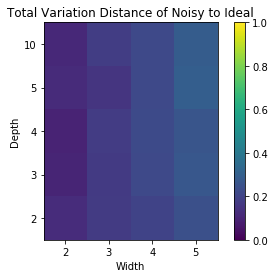

In [42]:
ax = plt.gca()
img = ax.imshow(Ztvd_ideal, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)


ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Total Variation Distance of Noisy to Ideal')
plt.show()

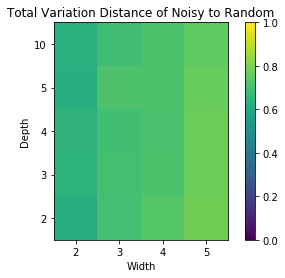

In [43]:
ax = plt.gca()
img = ax.imshow(Ztvd_rand, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Total Variation Distance of Noisy to Random')
plt.show()

## Data exploration

In [44]:
from scipy.optimize import curve_fit

In [45]:
shape = Zdata.shape
size = Zdata.size
width_1d = X.reshape((1,size))
depth_1d = Y.reshape((1,size))
data_1d = Zdata.reshape((1,size))
print(data_1d.shape)
print(width_1d.shape)

(1, 20)
(1, 20)


In [46]:
dims = np.zeros_like(width_1d)
dims[0,0] = shape[0]
dims[0,1] = shape[1]

xdata = np.vstack((dims, width_1d, depth_1d))
xdata

array([[ 5,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 2,  3,  4,  5,  2,  3,  4,  5,  2,  3,  4,  5,  2,  3,  4,  5,
         2,  3,  4,  5],
       [ 2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,
        10, 10, 10, 10]])

### Fitting models

Two parameter model 


$f(W,D,p_W,p_D) =  (1-p_W)^W * (1-p_D)^D $

The fidelity is proporional to $1 - p$

In [47]:
def two_param(x, pw, pd):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = (1-pw)**(widths) * (1-pd)**depths
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

One parameter model

$f(W,D,p) =  (1-p)^{W * D} $

In [48]:
def one_param(x,p):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = (1-p)**(widths * depths)
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

Josh: "From my prior work a better model to fit to is "

Pcheck$(W,D,p,a,b,c) = \exp[ -(a p^2 + b p + c)* W*D] $


In [49]:
def two_param_exp(x,p,a,b):
    num_depths, num_widths = x[0][:2]
    widths = x[1].reshape(num_depths, num_widths)
    depths = x[2].reshape(num_depths, num_widths)
    pcheck = np.exp(-(a*p + b) * widths * depths)
    rpcheck = pcheck.reshape((1, num_depths * num_widths))
    return rpcheck.ravel()

**Start with one paramter model**

In [50]:
pguess = 0.1
popt, pcov = curve_fit(one_param, xdata, data_1d.ravel(), p0=pguess, bounds=(0, 1))

In [51]:
print('The estimated error is p = ', str(np.round(popt[0],4)))
print('The estimated product of the one and two qubit fidelity is F = ', str(1-np.round(popt[0],4)))
#print('The one standard deviation on the estimate is ', str(np.round(np.sqrt(np.diag(pcov)[0]),5)))

The estimated error is p =  0.0109
The estimated product of the one and two qubit fidelity is F =  0.9891


In [52]:
zfit = one_param(xdata, popt)
Z_fit = zfit.reshape(shape)

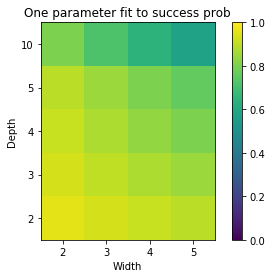

In [53]:
ax = plt.gca()
img = ax.imshow(Z_fit, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)


ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('One parameter fit to success prob')
plt.show()

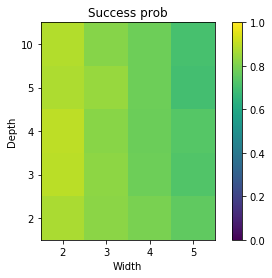

In [54]:
ax = plt.gca()
img = ax.imshow(Zdata, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0.0,vmax=1.0)


ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Success prob')
plt.show()

**Two parameter model**

In [55]:
# pguess2d_exp = [0.0276, 0.01, 0.4]
# popt2d, pcov2d = curve_fit(two_param_exp, xdata, data_1d.ravel(), p0=pguess2d, bounds=(0., 1))

In [56]:
popt2d, pcov2d = curve_fit(two_param, xdata, data_1d.ravel(), bounds=(0., 1))

In [57]:
popt2d

array([0.05919906, 0.00115833])

In [58]:
zfit2d = two_param(xdata, popt2d[0], popt2d[1])
Z_fit2d = zfit2d.reshape(shape)
print(Z_fit2d)

[[0.8830571  0.83078094 0.78159949 0.73532953]
 [0.88203423 0.82981863 0.78069414 0.73447778]
 [0.88101254 0.82885742 0.77978984 0.73362701]
 [0.87999204 0.82789733 0.77888658 0.73277723]
 [0.87490722 0.82311354 0.77438598 0.72854306]]


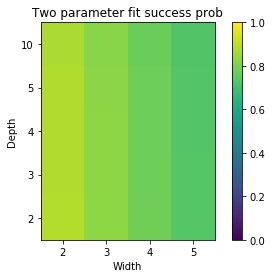

In [59]:
ax = plt.gca()
img = ax.imshow(Z_fit2d, interpolation='none', extent=extent,
                cmap='viridis', origin='lowerleft', vmin=0, vmax=1.0)

ax.set_xticks(range(len(widths)))
ax.set_xticklabels(widths)

ax.set_yticks(range(len(depths)))
ax.set_yticklabels(depths)

ax.set_aspect('equal')
plt.colorbar(img, ax=ax)
plt.xlabel('Width')
plt.ylabel('Depth')
plt.title('Two parameter fit success prob')
plt.show()

## Plot the distribution of sublattice widths

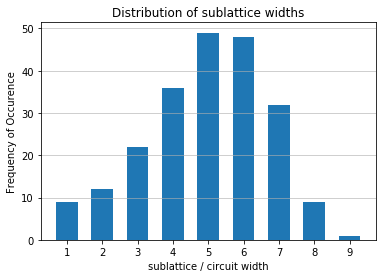

In [60]:
G = perfect_qc.qubit_topology()
len(perfect_qc.qubit_topology())
# distribution of graph lengths
distr = []
for num_nodes in range(1, len(G.nodes) + 1):
    listg = generate_connected_subgraphs(G, num_nodes)
    distr.append(len(listg))

cir_wid = list(range(1, len(G.nodes) + 1))
plt.bar(cir_wid, distr, width=0.61, align='center')
plt.xticks(cir_wid)
plt.xlabel('sublattice / circuit width')
plt.ylabel('Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of sublattice widths')
plt.show()